# Survival analysis using pyradiomics features.
Data presented on 20180918 using slides: ctDNA_survival_20180910.pptx.

## Materials:
- 13 subjects
- First two timepoints (t1 and t2) subject to analysis
- Manual segmentation performed on the series of the highest resolution
- Extracted radiomic features within the delineated tumor using PyRadiomics
- Survival analysis: PFS (progression free survival) and OS (overall survival)
- Semi-automatic tumor segmentation

### PyRadiomics features:
- First Order Statistics (19 features)
- Shape-based (16 features)
- Gray Level Cooccurence Matrix (23 features)
- Gray Level Run Length Matrix (16 features)
- Gray Level Size Zone Matrix (16 features)
- Neigbouring Gray Tone Difference Matrix (5 features)
- Gray Level Dependence Matrix (14 features)

### Survival Analysis
- Important risk factors included:
    - Age
    - Number of metastatic sites
    - % T790M AF (allelic fraction)
- 1st principle component for each radiomic feature family
    - 7 PC features total
- Using the first timepoint t1 data
- Cox’s Proportional Hazard model
    - With L2 penalty of 0.1 (emperical)
- To see if the covariates are overfitted to a random survival outcome whatsoever
    - Survival outcome permuted 1000 times

In [102]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import sklearn.manifold as skmf
import sklearn.decomposition as skd
import lifelines
import seaborn as sns
import sys,os, time
from glob import glob

In [2]:
df=pd.read_csv('ctDNA_pyradiomics_v1.3.0_output_20180720.csv', index_col=0)

In [3]:
date_cols=['Date of Progression/Censure', 'Date of Death/Censure', 'Date of TKI start', 
           'Date of Baseline Scan', 'Follow up Scan']
df_master=pd.read_excel('072318_Radiogenomics_Clinical_Charactertics.xlsx', 
                        index_col=0, sheetname='Patient Information', 
                        parse_dates=date_cols)
#df_master.index=df_master.index.astype(str)

In [4]:
df_master['ResponseGroup']=df_master['RECIST Response']
df_master['ResponseGroup'].replace(to_replace=['Stable Disease', 'Partial Response', 'Progressive Disease'],
                                   value=[True, True, False], inplace=True)
df_master['Sex'].replace(to_replace=['Female', 'Male'], value=[0, 1], inplace=True)

In [6]:
df_master['RECIST Response'].value_counts()

Stable Disease         6
Partial Response       5
Progressive Disease    3
Name: RECIST Response, dtype: int64

```python
T_PFS, E_P = lifelines.utils.datetimes_to_durations(df_master['Date of TKI start'], 
                                                    df_master['Date of Progression/Censure'], 
                                                    freq='W')

T_OS, E_D = lifelines.utils.datetimes_to_durations(df_master['Date of TKI start'], 
                                                    df_master['Date of Death/Censure'], 
                                                    freq='W')```

Text(0.5,1,u'Overall Survival')

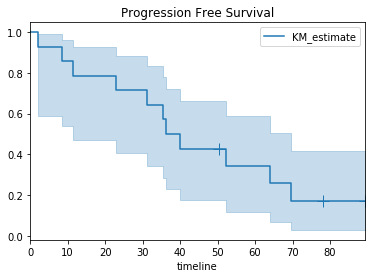

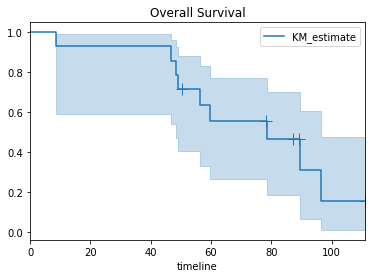

In [7]:
kmf = lifelines.KaplanMeierFitter()
#ix = (df_master['ResponseGroup'] == True) # Responders
kmf.fit(df_master['PFS (weeks)'], event_observed=df_master['Progression'])
ax = kmf.plot(show_censors=True, ci_show=True)
ax.set_title('Progression Free Survival')

kmf = lifelines.KaplanMeierFitter()
#ix = (df_master['ResponseGroup'] == True) # Responders
kmf.fit(df_master['OS (weeks)'], event_observed=df_master['Death'])
ax = kmf.plot(show_censors=True, ci_show=True)
ax.set_title('Overall Survival')

Text(0.5,1,u'Overall Survival')

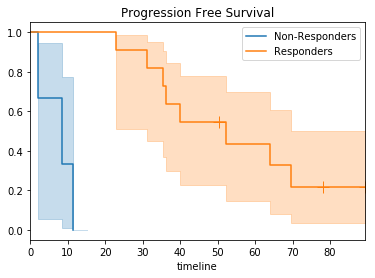

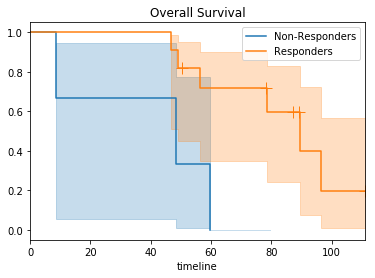

In [8]:
kmf = lifelines.KaplanMeierFitter()
ix = (df_master['ResponseGroup'] == True) # Responders
kmf.fit(df_master[~ix]['PFS (weeks)'], event_observed=df_master[~ix]['Progression'], label='Non-Responders')
ax = kmf.plot(show_censors=True, ci_show=True)

kmf.fit(df_master[ix]['PFS (weeks)'], event_observed=df_master[ix]['Progression'], label='Responders')
kmf.plot(show_censors=True, ci_show=True, ax=ax)
ax.set_title('Progression Free Survival')

kmf = lifelines.KaplanMeierFitter()
ix = (df_master['ResponseGroup'] == True) # Responders
kmf.fit(df_master[~ix]['OS (weeks)'], event_observed=df_master[~ix]['Death'], label='Non-Responders')
ax = kmf.plot(show_censors=True, ci_show=True)

kmf.fit(df_master[ix]['OS (weeks)'], event_observed=df_master[ix]['Death'], label='Responders')
kmf.plot(show_censors=True, ci_show=True, ax=ax)
ax.set_title('Overall Survival')

Text(0.5,1,u'Overall Survival')

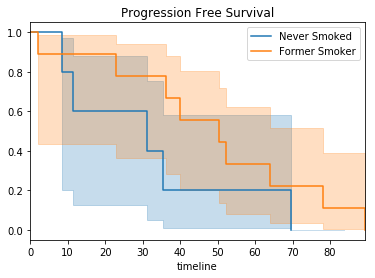

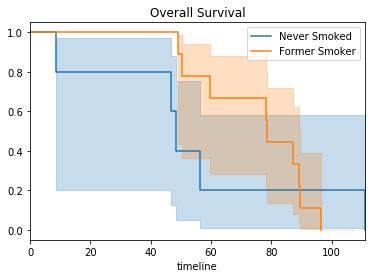

In [9]:
kmf = lifelines.KaplanMeierFitter()
ix = (df_master['Smoker'] == 'Never')
kmf.fit(df_master[~ix]['PFS (weeks)'], label='Never Smoked')
ax = kmf.plot()

kmf.fit(df_master[ix]['PFS (weeks)'], label='Former Smoker')
kmf.plot(ax=ax)
ax.set_title('Progression Free Survival')

kmf = lifelines.KaplanMeierFitter()
#ix = (df_master['ResponseGroup'] == 'Responders')
kmf.fit(df_master[~ix]['OS (weeks)'], label='Never Smoked')
ax = kmf.plot()

kmf.fit(df_master[ix]['OS (weeks)'], label='Former Smoker')
kmf.plot(ax=ax)
ax.set_title('Overall Survival')

In [10]:
df_merged=df.merge(df_master, left_on='PID', right_index=True)

In [11]:
pd.crosstab(df_merged.ResponseGroup, df_merged.Timepoint)

Timepoint,T1,T2
ResponseGroup,,
False,3,3
True,10,10


In [12]:
# prepare feature columns
radiomics_features=[i for i in df_merged.columns if 'original' in i]

d_feature={}
for feature in radiomics_features:
    key=feature.split('_')[1]
    #value=feature.split('_')[-1]
    if key in d_feature:
        d_feature[key].append(feature)
    else:
        d_feature[key]=[feature]
        
other_numeric_features=['Age at Enrollment', 'Number of Met Sites', '% Change Target lesion', 
                        'T790M AF %', 'EGFR Driver AF %', 'Number of mutations']
cols_features=radiomics_features+other_numeric_features
#cols_features.append('general_info_VoxelNum')
cols_number=['f%d' % i for i in range(1,len(cols_features)+1)]
#cols_number.append()

In [20]:
cols_features

['original_shape_Maximum3DDiameter',
 'original_shape_Compactness2',
 'original_shape_Maximum2DDiameterSlice',
 'original_shape_Sphericity',
 'original_shape_MinorAxis',
 'original_shape_Compactness1',
 'original_shape_Elongation',
 'original_shape_SurfaceVolumeRatio',
 'original_shape_Volume',
 'original_shape_SphericalDisproportion',
 'original_shape_MajorAxis',
 'original_shape_LeastAxis',
 'original_shape_Flatness',
 'original_shape_SurfaceArea',
 'original_shape_Maximum2DDiameterColumn',
 'original_shape_Maximum2DDiameterRow',
 'original_gldm_GrayLevelVariance',
 'original_gldm_HighGrayLevelEmphasis',
 'original_gldm_GrayLevelNonUniformityNormalized',
 'original_gldm_DependenceEntropy',
 'original_gldm_DependenceNonUniformity',
 'original_gldm_GrayLevelNonUniformity',
 'original_gldm_SmallDependenceEmphasis',
 'original_gldm_DependenceNonUniformityNormalized',
 'original_gldm_DependenceVariance',
 'original_gldm_LargeDependenceEmphasis',
 'original_gldm_LargeDependenceLowGrayLevel

In [13]:
len(cols_features)

119

In [14]:
valid_bl_id=df_merged[df_merged.Timepoint=='T1'].dropna(subset=[cols_features]).index
valid_fu_id=df_merged[df_merged.Timepoint=='T2'].dropna(subset=[cols_features]).index

df_merged_norm=df_merged.copy()
# normalize the feature timepoint-wise.
df_merged_norm.loc[valid_bl_id, cols_features]=stats.zscore(df_merged_norm.loc[valid_bl_id, cols_features])
df_merged_norm.loc[valid_fu_id, cols_features]=stats.zscore(df_merged_norm.loc[valid_fu_id, cols_features])

In [15]:
df_merged_norm.loc[valid_bl_id, cols_features].head()

,original_shape_Maximum3DDiameter,original_shape_Compactness2,original_shape_Maximum2DDiameterSlice,original_shape_Sphericity,original_shape_MinorAxis,original_shape_Compactness1,original_shape_Elongation,original_shape_SurfaceVolumeRatio,original_shape_Volume,original_shape_SphericalDisproportion,...,original_ngtdm_Complexity,original_ngtdm_Strength,original_ngtdm_Busyness,original_ngtdm_Contrast,Age at Enrollment,Number of Met Sites,% Change Target lesion,T790M AF %,EGFR Driver AF %,Number of mutations
Index,,,,,,,,,,,,,,,,,,,,,
9-20160920,0.531223,-0.782452,0.446278,-0.795249,0.713104,-0.801888,0.508438,-0.109111,-0.155902,0.692269,...,-0.368228,-0.431924,-0.068962,-0.320737,-0.326946,0.219971,-0.820068,2.370982,1.834541,0.533465
43-20160225,0.154900,-0.981860,0.324285,-1.236213,-0.298255,-1.170280,0.213598,1.522259,-0.679002,1.485942,...,-0.292214,-0.092768,-0.606528,-0.321160,0.145310,-0.733236,0.759975,-0.724845,-0.905025,-0.044455
83-20160728,-0.358457,-0.731037,-0.195375,-0.700956,-0.172402,-0.719274,0.355691,0.463297,-0.574035,0.552725,...,-0.361164,-0.411818,-0.304004,-0.321155,-0.704751,2.126383,0.337064,-0.255781,0.642459,-1.200296
113-20160804,0.993403,-1.027458,0.608709,-1.362394,0.639308,-1.270022,0.610722,0.582529,-0.225840,1.767872,...,-0.289545,-0.498195,-0.109274,-0.304381,1.750980,0.219971,-0.218007,-0.714422,-0.890216,1.111386
150-20160629,-0.374473,-0.084094,-0.567168,0.171514,-0.765033,0.104572,-1.283830,0.009696,-0.671261,-0.417018,...,0.031833,0.157276,-0.577847,-0.197879,-0.515849,0.219971,0.686553,-0.464254,-0.875408,-0.044455


In [16]:
cph=lifelines.CoxPHFitter()

covariates=['Age at Enrollment', 'Sex', 'ResponseGroup', 'PFS (weeks)', 'Progression']
cph.fit(df_merged_norm.loc[valid_bl_id, covariates], 
        duration_col=covariates[-2], event_col=covariates[-1])
cph.print_summary()

n=13, number of events=10

                      coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95   
Age at Enrollment   0.6113     1.8428    0.4595  1.3303 0.1834     -0.2893      1.5119   
Sex                -0.3095     0.7338    1.2811 -0.2416 0.8091     -2.8205      2.2014   
ResponseGroup     -15.5705     0.0000  517.7908 -0.0301 0.9760  -1030.4218    999.2808   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.836
Likelihood ratio test = 13.419 on 3 df, p=0.00381


n=13, number of events=9

                     coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95   
Age at Enrollment  1.0398     2.8286    0.7556  1.3760 0.1688     -0.4412      2.5208   
Sex               -0.4716     0.6240    1.7813 -0.2648 0.7912     -3.9629      3.0197   
ResponseGroup     -0.8806     0.4145    1.1818 -0.7452 0.4562     -3.1969      1.4357   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.767
Likelihood ratio test = 7.121 on 3 df, p=0.06812


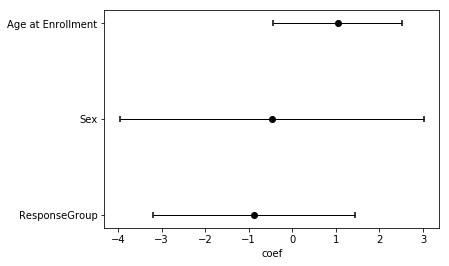

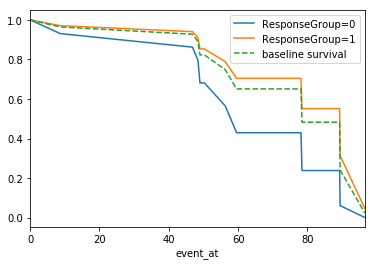

In [17]:
cph=lifelines.CoxPHFitter()

covariates=['Age at Enrollment', 'Sex', 'ResponseGroup', 'OS (weeks)', 'Death']
cph.fit(df_merged_norm.loc[valid_bl_id, covariates], 
        duration_col=covariates[-2], event_col=covariates[-1])
cph.print_summary()
cph.plot()
cph.plot_covariate_groups('ResponseGroup', [0, 1])

n=13, number of events=10

                                          coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95   
original_shape_Maximum3DDiameter        0.1199     1.1274    0.9958  0.1204 0.9041     -1.8318      2.0717   
original_shape_Compactness2            -0.1996     0.8190    0.9316 -0.2143 0.8303     -2.0256      1.6263   
original_shape_Maximum2DDiameterSlice   0.5550     1.7420    0.9449  0.5874 0.5570     -1.2970      2.4070   
original_shape_Sphericity               0.1430     1.1537    0.9571  0.1494 0.8812     -1.7329      2.0188   
original_shape_MinorAxis                0.2372     1.2677    0.9681  0.2450 0.8064     -1.6602      2.1347   
original_shape_Compactness1             0.0535     1.0550    0.9542  0.0561 0.9553     -1.8167      1.9237   
original_shape_Elongation              -0.1701     0.8436    0.6124 -0.2778 0.7812     -1.3704      1.0301   
original_shape_SurfaceVolumeRatio      -0.5136     0.5984    0.7532 -0.6819 0.4953     -1.989

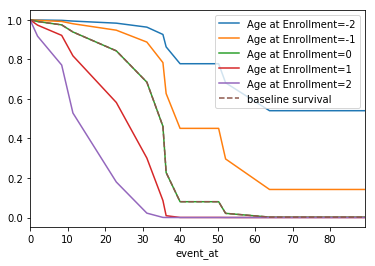

In [18]:
cph=lifelines.CoxPHFitter(penalizer=0.8)

covariates=['Age at Enrollment', 'Sex', 'ResponseGroup', 'PFS (weeks)', 'Progression']
covariates=d_feature['shape']+covariates
cph.fit(df_merged_norm.loc[valid_bl_id, covariates], 
        duration_col=covariates[-2], event_col=covariates[-1])
cph.print_summary()
cph.plot_covariate_groups('Age at Enrollment', [-2, -1, 0, 1, 2])

In [21]:
cph=lifelines.CoxPHFitter(penalizer=50)

covariates=['Sex', 'PFS (weeks)', 'Progression']
covariates=cols_features+covariates
cph.fit(df_merged_norm.loc[valid_bl_id, covariates], 
        duration_col=covariates[-2], event_col=covariates[-1])
cph.print_summary()

n=13, number of events=10

                                                      coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95   
original_shape_Maximum3DDiameter                    0.0101     1.0102    0.1336  0.0756 0.9397     -0.2518      0.2720   
original_shape_Compactness2                         0.0310     1.0314    0.1332  0.2323 0.8163     -0.2302      0.2921   
original_shape_Maximum2DDiameterSlice               0.0260     1.0263    0.1338  0.1941 0.8461     -0.2363      0.2882   
original_shape_Sphericity                           0.0331     1.0337    0.1325  0.2500 0.8026     -0.2266      0.2929   
original_shape_MinorAxis                            0.0225     1.0227    0.1338  0.1679 0.8667     -0.2399      0.2848   
original_shape_Compactness1                         0.0326     1.0331    0.1328  0.2455 0.8061     -0.2276      0.2928   
original_shape_Elongation                          -0.0156     0.9845    0.1305 -0.1198 0.9046     -0.2715      0.2402 

What about PCA on each family and get only the first component.

In [22]:
#d_pc={}
for ind in [valid_bl_id, valid_fu_id]:
    for i, key in enumerate(d_feature.keys()):
        pca=skd.PCA(n_components=1)

        features=d_feature[key]
        tmp=pca.fit_transform(df_merged_norm.loc[ind, features])
        df_merged_norm.loc[ind, key]=tmp

n=13, number of events=10

                     coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95   
gldm              -0.3673     0.6926    0.6300 -0.5829 0.5599     -1.6021      0.8676   
glcm              -0.1990     0.8196    0.3208 -0.6204 0.5350     -0.8277      0.4297   
shape             -0.2351     0.7905    0.2989 -0.7866 0.4315     -0.8209      0.3507   
firstorder         0.3521     1.4220    0.2576  1.3667 0.1717     -0.1528      0.8569   
glrlm              0.2769     1.3190    0.5582  0.4961 0.6198     -0.8171      1.3709   
glszm             -0.7261     0.4838    0.3221 -2.2542 0.0242     -1.3574     -0.0948  *
ngtdm              0.4162     1.5162    0.4246  0.9803 0.3269     -0.4159      1.2483   
Age at Enrollment  0.6357     1.8883    0.6308  1.0077 0.3136     -0.6007      1.8720   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.849
Likelihood ratio test = 14.529 on 8 df, p=0.06897


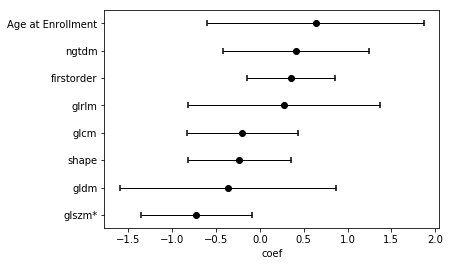

In [24]:
cph=lifelines.CoxPHFitter(penalizer=0.2)

covariates=['Age at Enrollment', 'PFS (weeks)', 'Progression']
covariates=d_feature.keys()+covariates
cph.fit(df_merged_norm.loc[valid_bl_id, covariates], 
        duration_col=covariates[-2], event_col=covariates[-1])
cph.print_summary()
cph.plot()
#cph.plot_covariate_groups()

n=13, number of events=10

              coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95   
gldm       -0.2659     0.7665    0.8520 -0.3121 0.7550     -1.9359      1.4041   
glcm       -0.2558     0.7743    0.3761 -0.6802 0.4964     -0.9930      0.4813   
shape      -0.4688     0.6257    0.2767 -1.6946 0.0902     -1.0111      0.0734  .
firstorder  0.4295     1.5365    0.2836  1.5147 0.1298     -0.1263      0.9853   
glrlm       0.3235     1.3819    0.7305  0.4428 0.6579     -1.1083      1.7552   
glszm      -0.8603     0.4230    0.3965 -2.1699 0.0300     -1.6374     -0.0833  *
ngtdm       0.6918     1.9973    0.4460  1.5509 0.1209     -0.1824      1.5660   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.836
Likelihood ratio test = 14.303 on 7 df, p=0.04604


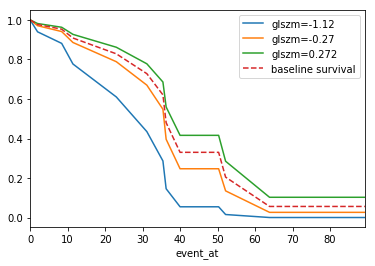

In [25]:
cph=lifelines.CoxPHFitter(penalizer=0.1)

covariates=['PFS (weeks)', 'Progression']
covariates=d_feature.keys()+covariates
cph.fit(df_merged_norm.loc[valid_bl_id, covariates], 
        duration_col=covariates[-2], event_col=covariates[-1])
cph.print_summary()
cph.plot_covariate_groups('glszm', [-1.12, -.270, .272])

In [26]:
cph=lifelines.CoxPHFitter(penalizer=0.1)

covariates=['Number of Met Sites', 'Number of mutations', '% Change Target lesion', 'T790M AF %', 
            'PFS (weeks)', 'Progression']
covariates=d_feature.keys()+covariates
cph.fit(df_merged_norm.loc[valid_bl_id, covariates], 
        duration_col=covariates[-2], event_col=covariates[-1])
cph.print_summary()

n=13, number of events=10

                          coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95   
gldm                   -0.6074     0.5448    0.9734 -0.6240 0.5326     -2.5153      1.3005   
glcm                   -0.3368     0.7140    0.4798 -0.7020 0.4827     -1.2772      0.6036   
shape                  -0.6412     0.5267    0.3547 -1.8075 0.0707     -1.3365      0.0541  .
firstorder              0.5726     1.7729    0.4391  1.3040 0.1922     -0.2880      1.4333   
glrlm                   0.3403     1.4053    0.7668  0.4437 0.6572     -1.1626      1.8432   
glszm                  -1.1540     0.3154    0.6055 -1.9060 0.0567     -2.3407      0.0327  .
ngtdm                   0.8809     2.4131    0.5458  1.6138 0.1066     -0.1889      1.9507   
Number of Met Sites     0.8433     2.3241    0.6254  1.3485 0.1775     -0.3824      2.0690   
Number of mutations    -0.0919     0.9122    0.9284 -0.0990 0.9212     -1.9116      1.7278   
% Change Target lesion  0.1950   


df=1, alpha=0.95, t_0=-1, null_distribution=chi squared

test_statistic      p   
        2.2074 0.1373
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 
0.137346194811
2.20744256369


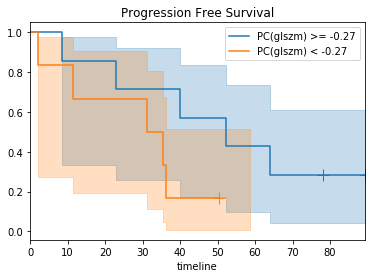

In [27]:
kmf = lifelines.KaplanMeierFitter()
feature_pc='glszm'
m=df_merged_norm.loc[valid_bl_id, feature_pc].median()
ix1 = df_merged_norm.loc[valid_bl_id].query('%s >= %.2f'%(feature_pc, m)).index
ix2 = df_merged_norm.loc[valid_bl_id].query('%s < %.2f'%(feature_pc, m)).index

kmf.fit(df_merged_norm.loc[ix1, 'PFS (weeks)'], event_observed=df_merged_norm.loc[ix1, 'Progression'], 
        label='PC(%s) >= %.2f'%(feature_pc, m))
ax = kmf.plot(show_censors=True, ci_show=True)

kmf.fit(df_merged_norm.loc[ix2, 'PFS (weeks)'], event_observed=df_merged_norm.loc[ix2, 'Progression'], 
        label='PC(%s) < %.2f'%(feature_pc, m))
kmf.plot(show_censors=True, ci_show=True, ax=ax)
ax.set_title('Progression Free Survival')

results=lifelines.statistics.logrank_test(df_merged_norm.loc[ix1, 'PFS (weeks)'], df_merged_norm.loc[ix2, 'PFS (weeks)'], 
                                          event_observed_A=df_merged_norm.loc[ix1, 'Progression'], 
                                          event_observed_B=df_merged_norm.loc[ix2, 'Progression'],)
results.print_summary()
print results.p_value
print results.test_statistic


df=1, alpha=0.95, t_0=-1, null_distribution=chi squared

test_statistic      p   
        0.6186 0.4316
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 
0.431585162259
0.618553931136


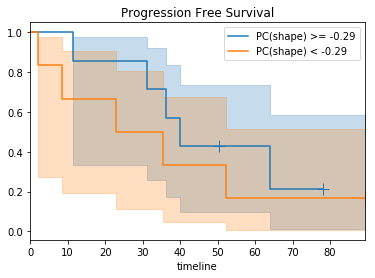

In [28]:
kmf = lifelines.KaplanMeierFitter()
feature_pc='shape'
m=df_merged_norm.loc[valid_bl_id, feature_pc].median()
ix1 = df_merged_norm.loc[valid_bl_id].query('%s >= %.2f'%(feature_pc, m)).index
ix2 = df_merged_norm.loc[valid_bl_id].query('%s < %.2f'%(feature_pc, m)).index

kmf.fit(df_merged_norm.loc[ix1, 'PFS (weeks)'], event_observed=df_merged_norm.loc[ix1, 'Progression'], 
        label='PC(%s) >= %.2f'%(feature_pc, m))
ax = kmf.plot(show_censors=True, ci_show=True)

kmf.fit(df_merged_norm.loc[ix2, 'PFS (weeks)'], event_observed=df_merged_norm.loc[ix2, 'Progression'], 
        label='PC(%s) < %.2f'%(feature_pc, m))
kmf.plot(show_censors=True, ci_show=True, ax=ax)
ax.set_title('Progression Free Survival')

results=lifelines.statistics.logrank_test(df_merged_norm.loc[ix1, 'PFS (weeks)'], df_merged_norm.loc[ix2, 'PFS (weeks)'], 
                                          event_observed_A=df_merged_norm.loc[ix1, 'Progression'], 
                                          event_observed_B=df_merged_norm.loc[ix2, 'Progression'],)
results.print_summary()
print results.p_value
print results.test_statistic

In [29]:
cph=lifelines.CoxPHFitter(penalizer=0.1)

covariates=['Number of Met Sites', 'Age at Enrollment', 'T790M AF %', 'PFS (weeks)', 'Progression']
#covariates=d_feature.keys()+covariates
cph.fit(df_merged_norm.loc[valid_bl_id, covariates], 
        duration_col=covariates[-2], event_col=covariates[-1])
cph.print_summary()

n=13, number of events=10

                      coef  exp(coef)  se(coef)      z      p  lower 0.95  upper 0.95   
Number of Met Sites 0.2390     1.2699    0.4200 0.5690 0.5694     -0.5842      1.0621   
Age at Enrollment   0.9700     2.6379    0.4127 2.3502 0.0188      0.1611      1.7789  *
T790M AF %          0.4238     1.5277    0.2842 1.4911 0.1359     -0.1333      0.9808   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.808
Likelihood ratio test = 8.138 on 3 df, p=0.04324


In [30]:
cph=lifelines.CoxPHFitter(penalizer=0.1)

covariates=['Number of Met Sites', 'Age at Enrollment', 'T790M AF %', 'OS (weeks)', 'Death']
#covariates=d_feature.keys()+covariates
cph.fit(df_merged_norm.loc[valid_bl_id, covariates], 
        duration_col=covariates[-2], event_col=covariates[-1])
cph.print_summary()

n=13, number of events=9

                       coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95   
Number of Met Sites -0.7101     0.4916    0.5692 -1.2475 0.2122     -1.8258      0.4056   
Age at Enrollment    1.2504     3.4916    0.6030  2.0736 0.0381      0.0685      2.4322  *
T790M AF %           0.3562     1.4279    0.4073  0.8744 0.3819     -0.4422      1.1545   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.800
Likelihood ratio test = 7.748 on 3 df, p=0.05151


In [31]:
# Progression free survival
cph=lifelines.CoxPHFitter(penalizer=0.1)

covariates=['Number of Met Sites', 'Age at Enrollment', 'T790M AF %', 'PFS (weeks)', 'Progression']
covariates=d_feature.keys()+covariates
cph.fit(df_merged_norm.loc[valid_bl_id, covariates], 
        duration_col=covariates[-2], event_col=covariates[-1])
cph.print_summary()

n=13, number of events=10

                       coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95   
gldm                -0.7647     0.4655    0.9026 -0.8472 0.3969     -2.5338      1.0044   
glcm                -0.7805     0.4582    0.5557 -1.4046 0.1602     -1.8697      0.3087   
shape               -0.3516     0.7036    0.4028 -0.8727 0.3828     -1.1411      0.4380   
firstorder           0.7926     2.2092    0.3780  2.0971 0.0360      0.0518      1.5334  *
glrlm                0.0500     1.0512    0.8228  0.0607 0.9516     -1.5628      1.6627   
glszm               -1.0542     0.3485    0.4541 -2.3214 0.0203     -1.9443     -0.1641  *
ngtdm                0.2001     1.2216    0.6072  0.3297 0.7417     -0.9898      1.3901   
Number of Met Sites  1.2838     3.6103    0.6479  1.9815 0.0475      0.0140      2.5536  *
Age at Enrollment    1.6250     5.0782    1.0953  1.4836 0.1379     -0.5218      3.7717   
T790M AF %           0.2621     1.2997    0.5328  0.4920 0.6227

In [34]:
# Overall survival
cph=lifelines.CoxPHFitter(penalizer=0.1)

covariates=['Number of Met Sites', 'Age at Enrollment', 'T790M AF %', 'OS (weeks)', 'Death']
covariates=d_feature.keys()+covariates
cph.fit(df_merged_norm.loc[valid_bl_id, covariates], 
        duration_col=covariates[-2], event_col=covariates[-1])
cph.print_summary()

n=13, number of events=9

                       coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95   
gldm                -0.7311     0.4814    0.9554 -0.7653 0.4441     -2.6037      1.1414   
glcm                -0.7200     0.4868    0.5620 -1.2812 0.2001     -1.8214      0.3815   
shape               -0.1078     0.8978    0.4272 -0.2524 0.8007     -0.9451      0.7294   
firstorder           0.8822     2.4163    0.4215  2.0931 0.0363      0.0561      1.7084  *
glrlm                0.1702     1.1855    0.8818  0.1930 0.8470     -1.5582      1.8985   
glszm               -0.9430     0.3895    0.6106 -1.5444 0.1225     -2.1396      0.2537   
ngtdm                0.2802     1.3234    0.6412  0.4370 0.6621     -0.9765      1.5369   
Number of Met Sites -0.5882     0.5553    1.1031 -0.5332 0.5939     -2.7501      1.5738   
Age at Enrollment    1.9069     6.7322    1.2148  1.5697 0.1165     -0.4741      4.2879   
T790M AF %           0.3421     1.4079    0.8728  0.3919 0.6951 

In [33]:
cph=lifelines.CoxPHFitter(penalizer=0.5)

covariates=['Number of Met Sites', 'Age at Enrollment', 'T790M AF %', 'PFS (weeks)', 'Progression']
covariates=d_feature.keys()+covariates
cph.fit(df_merged_norm.loc[valid_fu_id, covariates], 
        duration_col=covariates[-2], event_col=covariates[-1])
cph.print_summary()

n=10, number of events=7

                       coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95   
gldm                 0.0019     1.0019    0.4139  0.0046 0.9964     -0.8093      0.8131   
glcm                 0.2388     1.2697    0.2896  0.8247 0.4096     -0.3288      0.8064   
shape                0.2607     1.2978    0.3062  0.8513 0.3946     -0.3395      0.8609   
firstorder           0.0857     1.0895    0.2209  0.3880 0.6980     -0.3472      0.5186   
glrlm               -0.5103     0.6003    0.3638 -1.4025 0.1608     -1.2234      0.2028   
glszm               -0.1050     0.9003    0.3911 -0.2685 0.7883     -0.8716      0.6616   
ngtdm               -0.5569     0.5730    0.6123 -0.9096 0.3630     -1.7569      0.6431   
Number of Met Sites -0.0851     0.9185    0.6595 -0.1290 0.8974     -1.3777      1.2076   
Age at Enrollment    0.7509     2.1189    0.8408  0.8931 0.3718     -0.8971      2.3989   
T790M AF %          -0.0819     0.9214    0.5337 -0.1534 0.8781 

# Let's try permutation so that we can test if what we see is actually random.

In [61]:
tmp=df_merged_norm.copy()
survival_permute=tmp.loc[valid_bl_id, ['PFS (weeks)', 'Progression']]

In [71]:
tmp.loc[valid_bl_id, ['PFS (weeks)', 'Progression']]=np.random.permutation(survival_permute)
tmp.loc[valid_bl_id, ['PFS (weeks)', 'Progression']].sort_values('Progression').head()

,PFS (weeks),Progression
Index,,
9-20160920,89.285714,False
203-20161017,78.142857,False
349-20170615,50.285714,False
43-20160225,31.142857,True
83-20160728,8.428571,True


In [83]:
# Progression free survival
tmp.loc[valid_bl_id, ['PFS (weeks)', 'Progression']]=np.random.permutation(survival_permute)

cph=lifelines.CoxPHFitter(penalizer=0.1)

covariates=['Number of Met Sites', 'Age at Enrollment', 'T790M AF %', 'PFS (weeks)', 'Progression']
covariates=d_feature.keys()+covariates
cph.fit(tmp.loc[valid_bl_id, covariates], duration_col=covariates[-2], event_col=covariates[-1])
cph.print_summary()

n=13, number of events=10

                       coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95   
gldm                 0.8419     2.3209    0.8981  0.9375 0.3485     -0.9183      2.6022   
glcm                -0.3715     0.6897    0.3961 -0.9379 0.3483     -1.1477      0.4048   
shape               -0.9710     0.3787    0.4763 -2.0387 0.0415     -1.9045     -0.0375  *
firstorder          -0.4949     0.6096    0.4069 -1.2163 0.2239     -1.2924      0.3026   
glrlm               -0.0235     0.9767    0.6876 -0.0342 0.9727     -1.3712      1.3241   
glszm               -0.5866     0.5562    0.3894 -1.5064 0.1320     -1.3498      0.1766   
ngtdm                0.4670     1.5952    0.5719  0.8165 0.4142     -0.6540      1.5880   
Number of Met Sites -0.0970     0.9075    0.5265 -0.1843 0.8538     -1.1289      0.9349   
Age at Enrollment   -0.3967     0.6726    0.8310 -0.4773 0.6331     -2.0255      1.2321   
T790M AF %          -0.6025     0.5474    0.5436 -1.1083 0.2677

In [89]:
cph.score_

0.87671232876712324

In [86]:
cph.summary

,coef,exp(coef),se(coef),z,p,lower 0.95,upper 0.95
gldm,0.841943,2.320872,0.898120,0.937450,0.348527,-0.918341,2.602227
glcm,-0.371460,0.689726,0.396061,-0.937887,0.348302,-1.147725,0.404805
shape,-0.971013,0.378699,0.476296,-2.038675,0.041482,-1.904535,-0.037490
firstorder,-0.494895,0.609635,0.406882,-1.216310,0.223867,-1.292369,0.302580
glrlm,-0.023537,0.976738,0.687597,-0.034230,0.972694,-1.371203,1.324129
glszm,-0.586587,0.556222,0.389389,-1.506431,0.131956,-1.349775,0.176600
ngtdm,0.467005,1.595210,0.571942,0.816525,0.414200,-0.653981,1.587992
Number of Met Sites,-0.097021,0.907537,0.526487,-0.184279,0.853794,-1.128915,0.934874
Age at Enrollment,-0.396675,0.672553,0.831048,-0.477319,0.633135,-2.025498,1.232149
T790M AF %,-0.602531,0.547425,0.543634,-1.108339,0.267715,-1.668033,0.462972


Let's do permutation 1000 times

In [156]:
# Progression free survival

covariates=['Number of Met Sites', 'Age at Enrollment', 'T790M AF %', 'PFS (weeks)', 'Progression']
covariates=d_feature.keys()+covariates

n_permute=1000
c_scores=np.zeros(n_permute)
d_cph_summary={}
d_sig_features={}
df_sig_features=pd.DataFrame(index=covariates[:-2])
df_sig_features['Count']=0
    
np.random.seed(42)

for i in xrange(n_permute):
    j = (i + 1) / n_permute
    
    tmp.loc[valid_bl_id, ['PFS (weeks)', 'Progression']]=np.random.permutation(survival_permute)

    try:
        cph=lifelines.CoxPHFitter(penalizer=0.1)
        cph.fit(tmp.loc[valid_bl_id, covariates], duration_col=covariates[-2], event_col=covariates[-1])

        c_scores[i]=cph.score_
        d_cph_summary[i]=cph.summary
        d_sig_features[i]=cph.summary[cph.summary['p']<0.05].index.tolist()
        df_sig_features['Count']=df_sig_features['Count']+(cph.summary['p']<0.05).astype(int)
    except:
        c_scores[i]=np.nan
        d_cph_summary[i]=None
        d_sig_features[i]=[]
        
    # the exact output you're looking for:
    sys.stdout.write("\r[%-20s] %d%%" % ('='*int(20*j), 100*j))
    sys.stdout.flush()
    #time.sleep(0.05)

[====================] 100%

In [159]:
np.nanmean(c_scores), np.nanstd(c_scores)

(0.87489866860856536, 0.073607856456551005)

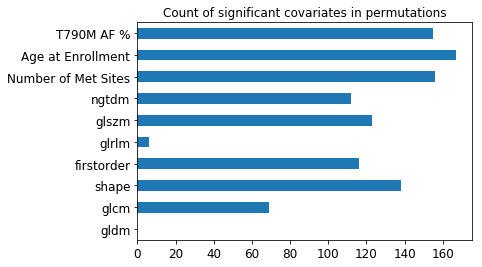

In [191]:
df_sig_features.plot.barh(fontsize=12, title='Count of significant covariates in permutations', legend=False)
plt.savefig('figures_20180911/bar_significant_feature_permutation.png', dpi=150, bbox_inches='tight')

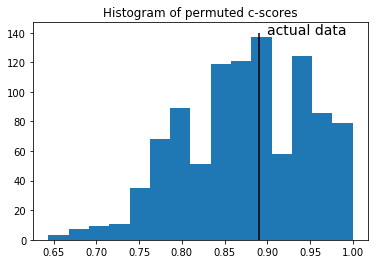

In [204]:
plt.hist(c_scores[~np.isnan(c_scores)], bins=15)
plt.vlines(0.89, 0, 140)
plt.text(0.90, 139, 'actual data', fontdict={'fontsize':14})
plt.title('Histogram of permuted c-scores')
plt.savefig('figures_20180911/histogram_cscore_permutation.png', dpi=150, bbox_inches='tight')
plt.show()

In [192]:
# Overall survival

tmp2=df_merged_norm.copy()
survival_permute2=tmp.loc[valid_bl_id, ['OS (weeks)', 'Death']]

covariates=['Number of Met Sites', 'Age at Enrollment', 'T790M AF %', 'OS (weeks)', 'Death']
covariates=d_feature.keys()+covariates

n_permute=1000
c_scores2=np.zeros(n_permute)
d_cph_summary2={}
d_sig_features2={}
df_sig_features2=pd.DataFrame(index=covariates[:-2])
df_sig_features2['Count']=0
    
np.random.seed(42)

for i in xrange(n_permute):
    j = (i + 1) / n_permute
    
    tmp.loc[valid_bl_id, ['OS (weeks)', 'Death']]=np.random.permutation(survival_permute2)

    try:
        cph2=lifelines.CoxPHFitter(penalizer=0.1)
        cph2.fit(tmp.loc[valid_bl_id, covariates], duration_col=covariates[-2], event_col=covariates[-1])

        c_scores2[i]=cph2.score_
        d_cph_summary2[i]=cph2.summary
        d_sig_features2[i]=cph2.summary[cph2.summary['p']<0.05].index.tolist()
        df_sig_features2['Count']=df_sig_features2['Count']+(cph2.summary['p']<0.05).astype(int)
    except:
        c_scores2[i]=np.nan
        d_cph_summary2[i]=None
        d_sig_features2[i]=[]
        
    # the exact output you're looking for:
    sys.stdout.write("\r[%-20s] %d%%" % ('='*int(20*j), 100*j))
    sys.stdout.flush()
    #time.sleep(0.05)

[====================] 100%

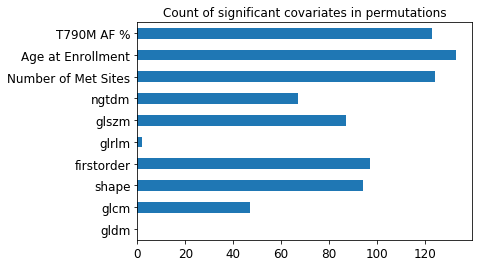

In [193]:
df_sig_features2.plot.barh(fontsize=12, title='Count of significant covariates in permutations', legend=False)
plt.savefig('figures_20180911/bar_significant_feature_permutation_os.png', dpi=150, bbox_inches='tight')

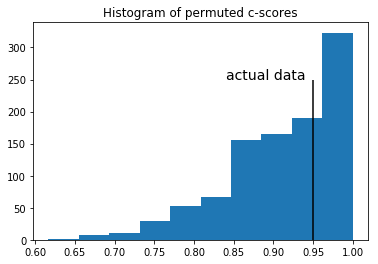

In [203]:
plt.hist(c_scores2[~np.isnan(c_scores2)], bins=10)
plt.vlines(0.95, 0, 250)
plt.text(0.84, 250, 'actual data', fontdict={'fontsize':14})
plt.title('Histogram of permuted c-scores')
plt.savefig('figures_20180911/histogram_cscore_permutation_os.png', dpi=150, bbox_inches='tight')
plt.show()

## Adding second PC to the model

In [163]:
list_pc2=[]
for i, key in enumerate(d_feature.keys()):
    pca=skd.PCA(n_components=2)
    
    features=d_feature[key]
    tmp_pcs=pca.fit_transform(df_merged_norm.loc[valid_bl_id, features])
    df_merged_norm.loc[valid_bl_id, key+'_PC2']=tmp_pcs[:,1]
    list_pc2.append(key+'_PC2')

In [164]:
cph=lifelines.CoxPHFitter(penalizer=0.1)

covariates=['PFS (weeks)', 'Progression']
covariates=d_feature.keys()+list_pc2+covariates
cph.fit(df_merged_norm.loc[valid_bl_id, covariates], 
        duration_col=covariates[-2], event_col=covariates[-1])
cph.print_summary()

n=13, number of events=10

                  coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95   
gldm           -0.0633     0.9387    0.9641 -0.0656 0.9477     -1.9529      1.8264   
glcm           -0.3851     0.6804    0.5672 -0.6789 0.4972     -1.4967      0.7266   
shape          -0.3726     0.6889    0.4287 -0.8693 0.3847     -1.2128      0.4675   
firstorder      0.3415     1.4070    0.4994  0.6838 0.4941     -0.6373      1.3202   
glrlm          -0.0713     0.9312    0.8305 -0.0859 0.9316     -1.6990      1.5564   
glszm          -0.7255     0.4841    0.8131 -0.8923 0.3722     -2.3192      0.8681   
ngtdm           0.4899     1.6322    0.8803  0.5566 0.5778     -1.2353      2.2152   
gldm_PC2        0.5351     1.7076    1.2775  0.4188 0.6753     -1.9687      3.0389   
glcm_PC2        0.1669     1.1816    1.0043  0.1662 0.8680     -1.8015      2.1353   
shape_PC2       0.6343     1.8857    0.5330  1.1901 0.2340     -0.4104      1.6789   
firstorder_PC2  0.4658     

In [165]:
cph=lifelines.CoxPHFitter(penalizer=0.1)

covariates=['PFS (weeks)', 'Progression']
covariates=list_pc2+covariates
cph.fit(df_merged_norm.loc[valid_bl_id, covariates], 
        duration_col=covariates[-2], event_col=covariates[-1])
cph.print_summary()

n=13, number of events=10

                  coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95   
gldm_PC2        1.3642     3.9125    0.8752  1.5587 0.1191     -0.3512      3.0795   
glcm_PC2        1.0457     2.8454    0.4227  2.4737 0.0134      0.2172      1.8743  *
shape_PC2       0.4999     1.6485    0.3298  1.5157 0.1296     -0.1465      1.1463   
firstorder_PC2  0.7046     2.0231    0.6075  1.1598 0.2461     -0.4861      1.8954   
glrlm_PC2      -0.9838     0.3739    0.6667 -1.4756 0.1400     -2.2905      0.3229   
glszm_PC2      -0.9214     0.3979    0.7113 -1.2954 0.1952     -2.3156      0.4727   
ngtdm_PC2      -0.1275     0.8803    0.5570 -0.2289 0.8189     -1.2193      0.9643   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.877
Likelihood ratio test = 15.916 on 7 df, p=0.02589



df=1, alpha=0.95, t_0=-1, null_distribution=chi squared

test_statistic      p   
        0.5028 0.4783
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 
0.478284478292
0.50277240414


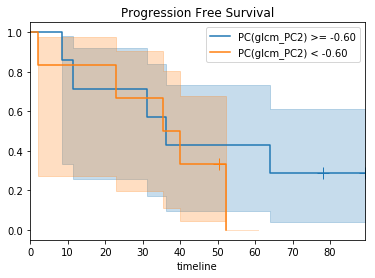

In [166]:
kmf = lifelines.KaplanMeierFitter()
feature_pc='glcm_PC2'
m=df_merged_norm.loc[valid_bl_id, feature_pc].median()
ix1 = df_merged_norm.loc[valid_bl_id].query('%s >= %.2f'%(feature_pc, m)).index
ix2 = df_merged_norm.loc[valid_bl_id].query('%s < %.2f'%(feature_pc, m)).index

kmf.fit(df_merged_norm.loc[ix1, 'PFS (weeks)'], event_observed=df_merged_norm.loc[ix1, 'Progression'], 
        label='PC(%s) >= %.2f'%(feature_pc, m))
ax = kmf.plot(show_censors=True, ci_show=True)

kmf.fit(df_merged_norm.loc[ix2, 'PFS (weeks)'], event_observed=df_merged_norm.loc[ix2, 'Progression'], 
        label='PC(%s) < %.2f'%(feature_pc, m))
kmf.plot(show_censors=True, ci_show=True, ax=ax)
ax.set_title('Progression Free Survival')

results=lifelines.statistics.logrank_test(df_merged_norm.loc[ix1, 'PFS (weeks)'], df_merged_norm.loc[ix2, 'PFS (weeks)'], 
                                          event_observed_A=df_merged_norm.loc[ix1, 'Progression'], 
                                          event_observed_B=df_merged_norm.loc[ix2, 'Progression'],)
results.print_summary()
print results.p_value
print results.test_statistic

--------------

n=13, number of events=9

              coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95   
gldm       -0.2157     0.8059    0.3214 -0.6713 0.5020     -0.8456      0.4141   
glcm       -0.0873     0.9164    0.1854 -0.4708 0.6378     -0.4507      0.2761   
shape      -0.1651     0.8478    0.1826 -0.9042 0.3659     -0.5231      0.1928   
firstorder  0.2175     1.2430    0.1769  1.2299 0.2187     -0.1291      0.5641   
glrlm       0.1010     1.1063    0.2849  0.3546 0.7229     -0.4573      0.6594   
glszm      -0.3671     0.6927    0.2637 -1.3924 0.1638     -0.8839      0.1496   
ngtdm       0.3468     1.4145    0.2646  1.3108 0.1899     -0.1717      0.8653   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.883
Likelihood ratio test = 8.730 on 7 df, p=0.27263


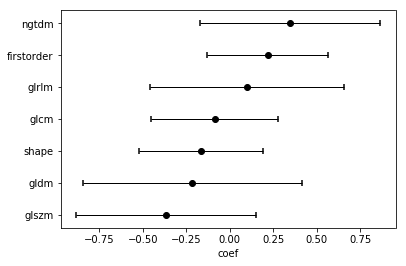

In [129]:
cph=lifelines.CoxPHFitter(penalizer=1)

covariates=['OS (weeks)', 'Death']
covariates=d_feature.keys()+covariates
cph.fit(df_merged_norm.loc[valid_bl_id, covariates], 
        duration_col=covariates[-2], event_col=covariates[-1])
cph.print_summary()
cph.plot()

In [185]:
df_merged_norm.loc[valid_fu_id, covariates].head()

,gldm,glcm,shape,firstorder,glrlm,glszm,ngtdm,Number of Met Sites,Age at Enrollment,T790M AF %,PFS (weeks),Progression
Index,,,,,,,,,,,,
9-20170227,0.273770,1.500612,2.247004,-1.581238,1.187137,-1.203711,-0.755920,0.48795,0.090212,2.434517,52.142857,True
43-20160705,-3.329897,-4.543581,-0.639516,0.840031,-1.296809,-2.955137,0.624950,-0.48795,0.734582,-0.688816,63.857143,True
83-20161111,0.562005,2.618037,-1.060817,-2.842170,-0.032162,1.461822,-1.078598,2.43975,-0.425285,-0.215584,40.000000,True
150-20161012,-2.419201,-5.651937,-0.568702,7.714615,-3.202758,-1.834258,-0.652712,0.48795,-0.167536,-0.425909,36.285714,True
162-20160608,1.628911,0.845173,6.533117,2.636491,0.863970,-0.476220,-1.245242,-1.46385,0.090212,1.193597,8.428571,True
